<a href="https://colab.research.google.com/github/J-Schwedler/BA-Schwedler/blob/main/BA_Schwedler_Auswertung.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Datensätze automatisch bereinigen

In [ ]:
!pip install pandas --quiet

import pandas as pd
from pathlib import Path
import unicodedata, re

base_path = Path("/content/drive/MyDrive/BA_Questionaire")

files = [
    base_path / 'morning1.csv', base_path / 'evening1.csv',
    base_path / 'morning2.csv', base_path / 'evening2.csv',
    base_path / 'morning3.csv', base_path / 'evening3.csv'
]

def clean_colname(c):
    if c is None: return ''
    s = str(c)
    s = unicodedata.normalize('NFKC', s)
    s = ' '.join(s.split())
    return s.strip()

def norm_pid(v):
    if pd.isna(v): return ''
    s = str(v)
    s = unicodedata.normalize('NFKC', s)
    s = re.sub(r'[\r\n\t]+', ' ', s)
    s = ' '.join(s.split())
    return s.strip()

def valid_prolific(pid):
    if pid == '':
        return False
    if '+' in pid:
        return False
    s = pid.strip()
    # nur Zahlen?
    if re.fullmatch(r'\d+', s):
        return False
    # nur Buchstaben (unicode letters)
    if re.fullmatch(r'[^\W\d_]+', s, flags=re.UNICODE):
        return False
    return True

# Lade und schreibe bereinigte Dateien
for p in files:
    if not p.exists():
        print(f"Datei nicht gefunden, übersprungen: {p}")
        continue
    try:
        df = pd.read_csv(p, sep=';', encoding='utf-8', dtype=str, low_memory=False)
        if df.shape[1] == 1:
            df2 = pd.read_csv(p, sep=',', encoding='utf-8', dtype=str, low_memory=False)
            if df2.shape[1] > 1:
                df = df2
    except Exception:
        df = pd.read_csv(p, sep=None, engine='python', encoding='utf-8', dtype=str, low_memory=False)

    df = df.rename(columns={c: clean_colname(c) for c in df.columns})

    prolific_col_candidates = [
        'ProlificID. Please enter your Prolific ID',
        'ProlificID', 'prolificid', 'prolific id', 'participantid', 'participant id'
    ]
    prolific_col = None
    for c in df.columns:
        if c.strip().lower() == 'prolificid. please enter your prolific id'.lower():
            prolific_col = c
            break
    if prolific_col is None:
        for c in df.columns:
            if 'prolific' in c.strip().lower():
                prolific_col = c
                break
    if prolific_col is None:
        prolific_col = df.columns[0]

    # Erzeuge neue Spalte normalisierte ID für Filterung
    df['_prolific_norm'] = df[prolific_col].map(norm_pid).fillna('')

    # Filter anwenden
    mask_valid = df['_prolific_norm'].map(valid_prolific)
    df_cleaned = df[mask_valid].drop(columns=['_prolific_norm'])

    # Schreibe bereinigte Datei
    out_name = p.with_name(p.stem + "_cleaned.csv")
    df_cleaned.to_csv(out_name, sep=';', index=False, encoding='utf-8')
    print(f"Wrote {out_name} ({len(df_cleaned)} rows, from {p.name} total {len(df)})")


Wrote /content/drive/MyDrive/BA_Questionaire/morning1_cleaned.csv (88 rows, from morning1.csv total 91)
Wrote /content/drive/MyDrive/BA_Questionaire/evening1_cleaned.csv (65 rows, from evening1.csv total 67)
Wrote /content/drive/MyDrive/BA_Questionaire/morning2_cleaned.csv (58 rows, from morning2.csv total 60)
Wrote /content/drive/MyDrive/BA_Questionaire/evening2_cleaned.csv (55 rows, from evening2.csv total 57)
Wrote /content/drive/MyDrive/BA_Questionaire/morning3_cleaned.csv (51 rows, from morning3.csv total 53)
Wrote /content/drive/MyDrive/BA_Questionaire/evening3_cleaned.csv (52 rows, from evening3.csv total 54)


Datensätze bereinigen

In [ ]:
!pip install pandas --quiet
import pandas as pd
from pathlib import Path
from collections import defaultdict
import numpy as np
import unicodedata, re, os

path = Path("/content/drive/MyDrive/BA_Questionaire")
out_dir = path / 'filtered'
out_dir.mkdir(parents=True, exist_ok=True)

files = [
   f'{path}/morning1_cleaned.csv', f'{path}/evening1_cleaned.csv',
   f'{path}/morning2_cleaned.csv', f'{path}/evening2_cleaned.csv',
   f'{path}/morning3_cleaned.csv', f'{path}/evening3_cleaned.csv'
]

att_col_1 = 'distractor1[SART5]. Examination of Attention  Please select the first option.  []'
att_col_2 = 'distraction5[SQ001]. Please select the fifth option. []'
prolific_col = 'ProlificID. Please enter your Prolific ID'

def clean_colname(c):
    if c is None: return ''
    s = str(c)
    s = unicodedata.normalize('NFKC', s)
    s = ' '.join(s.split())
    return s.strip()

def norm_val(v):
    if pd.isna(v): return ''
    s = str(v)
    s = unicodedata.normalize('NFKC', s)
    s = re.sub(r'[\r\n\t]+', ' ', s)
    s = ' '.join(s.split())
    return s.strip().lower()

def is_correct_att(v, expected_digits):
    s = norm_val(v)
    if not s: return False
    if s in expected_digits: return True
    m = re.match(r'(\d+)', s)
    if m and m.group(1) in expected_digits: return True
    word_map = {
        '1': {'1','one','first','erste','eins','1.'},
        '5': {'5','five','fifth','fünf','fünfte','5.'}
    }
    for d in expected_digits:
        for w in word_map.get(d, set()):
            if w in s.split() or w in s:
                return True
    if re.search(r'\b(?:option|opt|auswahl|choice)\b.*?(\d+)', s):
        m2 = re.search(r'(\d+)', s)
        if m2 and m2.group(1) in expected_digits:
            return True
    return False

# Lade und normalisiere Spalten
dfs = {}
for fn in files:
    p = Path(fn)
    if not p.exists():
        raise FileNotFoundError(f"File not found: {fn}")
    df = pd.read_csv(fn, sep=';', encoding='utf-8', dtype=str, low_memory=False)
    df = df.rename(columns={c: clean_colname(c) for c in df.columns})
    dfs[fn] = df

att_col_1 = clean_colname(att_col_1)
att_col_2 = clean_colname(att_col_2)
prolific_col = clean_colname(prolific_col)

# Prüfe Prolific-Spalte
for fn, df in dfs.items():
    if prolific_col not in df.columns:
        raise KeyError(f"ProlificID-Spalte nicht gefunden in {fn}")

# IDs in allen Dateien
sets = []
for fn, df in dfs.items():
    ids = set(df[prolific_col].dropna().astype(str).str.strip())
    #remove suspicious ID
    ids.remove('5555555555eeeeee55555555')
    sets.append(ids)
common_ids = set.intersection(*sets)
print("Anzahl ProlificIDs in allen 6 Dateien:", len(common_ids))

correct_counts = defaultdict(int)
for fn, df in dfs.items():
    col1_exists = att_col_1 in df.columns
    col2_exists = att_col_2 in df.columns
    cols = [prolific_col]
    if col1_exists: cols.append(att_col_1)
    if col2_exists: cols.append(att_col_2)
    for _, row in df[cols].iterrows():
        pid = str(row[prolific_col]).strip()
        if pid == '' or pid not in common_ids:
            continue
        if col1_exists and is_correct_att(row.get(att_col_1, ''), {'1'}):
            correct_counts[pid] += 1
        if col2_exists and is_correct_att(row.get(att_col_2, ''), {'5'}):
            correct_counts[pid] += 1

qualified_ids = {pid for pid, cnt in correct_counts.items() if cnt >= 11}
final_ids = common_ids.intersection(qualified_ids)
print("Anzahl finaler IDs (in allen 6 Dateien & >=11 AC):", len(final_ids))

for fn, df in dfs.items():
    filtered = df[df[prolific_col].astype(str).str.strip().isin(final_ids)].copy()
    out_name = out_dir / f"{Path(fn).stem}_filtered.csv"
    filtered.to_csv(out_name, sep=';', index=False, encoding='utf-8')
    print("Wrote (original-filter) ", out_name, len(filtered))

for filtered_fn in sorted(out_dir.glob("*_filtered.csv")):
    dfA = pd.read_csv(filtered_fn, sep=';', encoding='utf-8', dtype=str, low_memory=False)
    dfA = dfA.rename(columns={c: clean_colname(c) for c in dfA.columns})

    # bei duplicates erstes nehmen
    dfA = dfA.sort_values(by=prolific_col, kind='stable').reset_index(drop=True)
    df_selected = dfA.groupby(prolific_col, sort=False).first().reset_index()

    out_name = out_dir / f"{filtered_fn.stem}_final.csv"
    df_selected.to_csv(out_name, sep=';', index=False, encoding='utf-8')
    print("Wrote final ", out_name, len(df_selected))


Anzahl ProlificIDs in allen 6 Dateien: 49
Anzahl finaler IDs (in allen 6 Dateien & >=11 AC): 46
Wrote (original-filter)  /content/drive/MyDrive/BA_Questionaire/filtered/morning1_cleaned_filtered.csv 49
Wrote (original-filter)  /content/drive/MyDrive/BA_Questionaire/filtered/evening1_cleaned_filtered.csv 48
Wrote (original-filter)  /content/drive/MyDrive/BA_Questionaire/filtered/morning2_cleaned_filtered.csv 47
Wrote (original-filter)  /content/drive/MyDrive/BA_Questionaire/filtered/evening2_cleaned_filtered.csv 46
Wrote (original-filter)  /content/drive/MyDrive/BA_Questionaire/filtered/morning3_cleaned_filtered.csv 46
Wrote (original-filter)  /content/drive/MyDrive/BA_Questionaire/filtered/evening3_cleaned_filtered.csv 47
Wrote final  /content/drive/MyDrive/BA_Questionaire/filtered/evening1_cleaned_filtered_final.csv 46
Wrote final  /content/drive/MyDrive/BA_Questionaire/filtered/evening2_cleaned_filtered_final.csv 46
Wrote final  /content/drive/MyDrive/BA_Questionaire/filtered/evening

Mittelwerte & SD Teilnehmer (Demografie)

In [ ]:
!pip install pandas --quiet
import pandas as pd
from pathlib import Path
from collections import defaultdict
import numpy as np
import unicodedata, re, os

path = Path("/content/drive/MyDrive/BA_Questionaire/filtered")
out_dir = path / 'filtered'
out_dir.mkdir(parents=True, exist_ok=True)

files = [
   f'{path}/morning1_cleaned_filtered_final.csv'
]

age_col = 'age. How old are you? (in years)'
gender_col = 'gender. What gender do you identify yourself with?'
education_col = 'education. What is your highest educational level?'
job_col = 'job. What is the best way to describe your professional status?'
license_col = "license. How long do you have a driver's license? (in years)"
driving_frequency_col = "drivingfrequency. How often do you drive a car/motorcycle/scooter or similar?"
driving_distance_col ="distance. How many kilometers did you drive by car last year?"

def clean_colname(c):
    if c is None: return ''
    s = str(c)
    s = unicodedata.normalize('NFKC', s)
    s = ' '.join(s.split())
    return s.strip()

# Lade und normalisiere Spalten
dfs = {}
for fn in files:
    p = Path(fn)
    if not p.exists():
        raise FileNotFoundError(f"File not found: {fn}")
    df = pd.read_csv(fn, sep=';', encoding='utf-8', dtype=str, low_memory=False)
    df = df.rename(columns={c: clean_colname(c) for c in df.columns})
    dfs[fn] = df

age_col = clean_colname(age_col)
gender_col = clean_colname(gender_col)
education_col = clean_colname(education_col)
job_col = clean_colname(job_col)
license_col = clean_colname(license_col)
driving_frequency_col = clean_colname(driving_frequency_col)
driving_distance_col = clean_colname(driving_distance_col)

correct_counts = defaultdict(int)
for fn, df in dfs.items():
    age_col_exists = age_col in df.columns
    gender_col_exists = gender_col in df.columns
    education_col_exists = education_col in df.columns
    job_col_exists = job_col in df.columns
    license_col_exists = license_col in df.columns
    driving_frequency_col_exists = driving_frequency_col in df.columns
    driving_distance_col_exists = driving_distance_col in df.columns
    cols = []
    if age_col_exists: cols.append(age_col)
    if gender_col_exists: cols.append(gender_col)
    if education_col_exists: cols.append(education_col)
    if job_col_exists: cols.append(job_col)
    if license_col_exists: cols.append(license_col)
    if driving_frequency_col_exists: cols.append(driving_frequency_col)
    if driving_distance_col_exists: cols.append(driving_distance_col)

def to_numeric_series(s):
    return pd.to_numeric(s.astype(str).str.replace(',', '.', regex=False).replace({'nan': None, 'None': None, '': None}), errors='coerce')

def freq_table(series):
    s = series.astype(str).replace({'nan': None, 'None': None})
    counts = s.value_counts(dropna=False).sort_index()
    props = (counts / counts.sum()) * 100
    return pd.DataFrame({'count': counts, 'percent': props})

numeric_cols = [age_col, license_col]
categorical_cols = [gender_col, education_col, job_col, driving_frequency_col, driving_distance_col]

for fn, df in dfs.items():
    age_col_exists = age_col in df.columns
    gender_col_exists = gender_col in df.columns
    education_col_exists = education_col in df.columns
    job_col_exists = job_col in df.columns
    license_col_exists = license_col in df.columns
    driving_frequency_col_exists = driving_frequency_col in df.columns
    driving_distance_col_exists = driving_distance_col in df.columns

    # Numerische Auswertung für age und license
    for col in numeric_cols:
        if col in df.columns:
            ser = to_numeric_series(df[col])
            cnt = int(ser.count())
            mean = ser.mean() if cnt>0 else np.nan
            mn = ser.min() if cnt>0 else np.nan
            mx = ser.max() if cnt>0 else np.nan
            sd = ser.std(ddof=1) if cnt>1 else np.nan
            print(f"\n{col}:")
            print(f"  count = {cnt}")
            print(f"  mean  = {mean}")
            print(f"  min   = {mn}")
            print(f"  max   = {mx}")
            print(f"  std   = {sd}")
        else:
            print(f"\n{col}: NOT PRESENT")

    for col in categorical_cols:
        if col in df.columns:
            tab = freq_table(df[col])
            print(tab.to_string())
        else:
            print(f"\n{col}: NOT PRESENT")




age. How old are you? (in years):
  count = 46
  mean  = 36.26086956521739
  min   = 19
  max   = 61
  std   = 9.668815353401069

license. How long do you have a driver's license? (in years):
  count = 46
  mean  = 16.5
  min   = 2
  max   = 40
  std   = 10.383212947402702
                                                    count    percent
gender. What gender do you identify yourself with?                  
A1                                                     24  52.173913
A2                                                     21  45.652174
A4                                                      1   2.173913
                                                    count    percent
education. What is your highest educational level?                  
A3                                                     13  28.260870
A4                                                     31  67.391304
A5                                                      2   4.347826
                                   

Datenanalyse (M & SD) Gruppe


File: /content/drive/MyDrive/BA_Questionaire/filtered/morning1_cleaned_filtered_final.csv

=== Aggregated for this file ===
trust:
  total_count = 414
  total_mean  = 6.151368760064412
  total_std   = 2.7943179991295306
perceivedSafe:
  total_count = 184
  total_mean  = 8.061594202898549
  total_std   = 1.6488514873281748
percept:
  total_count = 138
  total_mean  = 7.041062801932366
  total_std   = 2.925252333422575
predict:
  total_count = 46
  total_mean  = 5.217391304347827
  total_std   = 3.3812974289076547
driveStyle:
  total_count = 230
  total_mean  = 7.391304347826087
  total_std   = 2.1540663145912906
accept:
  total_count = 414
  total_mean  = 8.109903381642512
  total_std   = 1.8751912871820966

File: /content/drive/MyDrive/BA_Questionaire/filtered/evening1_cleaned_filtered_final.csv

=== Aggregated for this file ===
trust:
  total_count = 414
  total_mean  = 6.0245571658615145
  total_std   = 2.944194573049125
perceivedSafe:
  total_count = 184
  total_mean  = 8.451086956

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

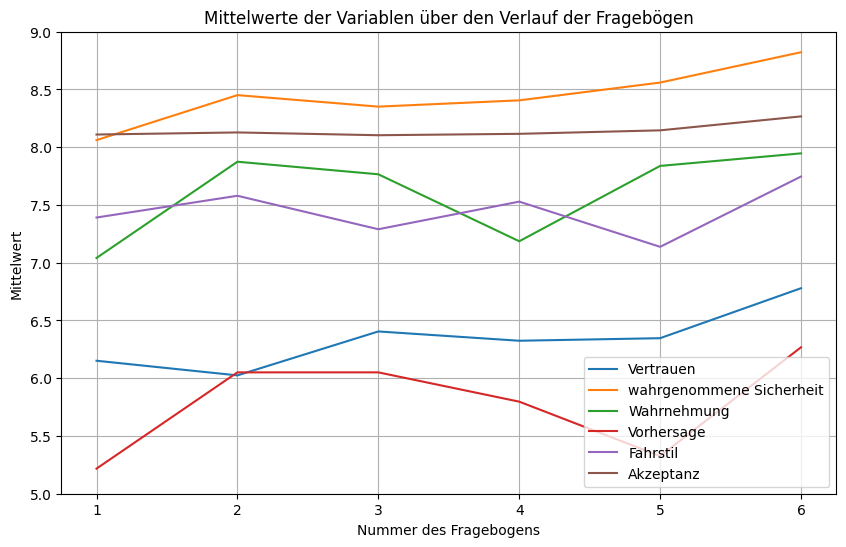

In [ ]:
!pip install pandas --quiet
import pandas as pd
from pathlib import Path
from collections import defaultdict
import numpy as np
import unicodedata, re, os
import math
import matplotlib.pyplot as plt


path = Path("/content/drive/MyDrive/BA_Questionaire/filtered")
out_dir = path / 'filtered'
out_dir.mkdir(parents=True, exist_ok=True)

max_value = -999
min_value=-999
files = [
   f'{path}/morning1_cleaned_filtered_final.csv', f'{path}/evening1_cleaned_filtered_final.csv',
   f'{path}/morning2_cleaned_filtered_final.csv', f'{path}/evening2_cleaned_filtered_final.csv',
   f'{path}/morning3_cleaned_filtered_final.csv', f'{path}/evening3_cleaned_filtered_final.csv'
]

#trust & predict zsm
trust1_col = 'Trust[SQ001]. Evaluate the following statements: [I can rely on the highly automated vehicle.]'
trust2_col = 'Trust[SQ002]. Evaluate the following statements: [I trust the highly automated vehicle.]'
trust3_col = 'Trust[SQ003]. Evaluate the following statements: [The automated vehicle state was always clear to me.]'
#invert next line
trust4_col = 'Trust[SQ004]. Evaluate the following statements: [The automated vehicle reacts unpredictably.]'
trust5_col = 'Trust[SQ005]. Evaluate the following statements: [I was able to understand why things happened.]'
#invert next line
trust6_col = "Trust[SQ006]. Evaluate the following statements: [it's difficult to identify what the automated vehicle will do next.]"
#invert next line
trust7_col = "perception[performbetter]. Please indicate your agreement with following statements. [I would have performed better than the automated vehicle in this situation.]"
trust8_col = 'ownq[expected]. Please answer the questions. [The automated vehicle drove as I expected at all times.]'
predict1_col = 'perception[willdo]. Please indicate your agreement with following statements. [It was always clear what the automated vehicle will do next.]'

#perceived safety
perceivedSafe1_col = 'perceivedSafety[SQ001]. How would you estimate your current emotional state? [Anxious | Relaxed]'
perceivedSafe2_col = 'perceivedSafety[SQ002]. How would you estimate your current emotional state? [Agitated | Calm]'
perceivedSafe3_col = 'perceivedSafety[SQ003]. How would you estimate your current emotional state? [Unsafe | Safe]'
perceivedSafe4_col = 'perceivedSafety[SQ004]. How would you estimate your current emotional state? [Timid | Confident]'

# Perception of Pedestrians, Vehicles, and Signposts
percept1_col = 'perception[p1b]. Please indicate your agreement with following statements. [The automated vehicle recognizes all pedestrians in every situation perfectly.]'
percept2_col = 'perception[p2b]. Please indicate your agreement with following statements. [The automated vehicle recognizes all vehicles in every situation perfectly.]'
percept3_col = 'perception[p3b]. Please indicate your agreement with following statements. [The automated vehicle recognizes all signposts in every situation perfectly.]'
# Prediction of Pedestrians
predict_col = 'perception[pintention]. Please indicate your agreement with following statements. [The automated vehicle predicts all pedestrian intentions in every scene perfectly.]'
#korrelierend
predict_correl_col = "ownq[morepre]. Please answer the questions. [I would have liked more information regarding the automated vehicle's predictions (how does the automated vehicle think the future will be).]"
# Fahrstil (longitudinal & lateral guidance)
driveStyle1_col = 'perception[p4b]. Please indicate your agreement with following statements. [The automated vehicle has perfect longitudinal guidance (braking, acceleration, ...).]'
driveStyle2_col = 'perception[p5b]. Please indicate your agreement with following statements. [The automated vehicle has perfect lateral guidance (keeping track, staying on the road).]'
#invert next line
driveStyle3_col = 'perception[unsafeJudgement]. Please indicate your agreement with following statements. [The automated vehicle made an unsafe judgement in this situation.]'
driveStyle4_col = 'perception[reactapprop]. Please indicate your agreement with following statements. [The automated vehicle reacted appropriately to the environment.]'
#invert next line
driveStyle5_col = 'drivingstyle[SART1]. Driving Style How would you rate the driving style of the automated vehicle? []'


#Acceptance
#invert next line
accept1_col = 'vanDerAccept[useful]. Please rate the following regarding your judgment of the system. [Useful | Useless ]'
#invert next line
accept2_col = 'vanDerAccept[pleas]. Please rate the following regarding your judgment of the system. [Pleasant | Unpleasant]'
accept3_col = 'vanDerAccept[bad]. Please rate the following regarding your judgment of the system. [Bad | Good]'
#invert next line
accept4_col = 'vanDerAccept[nice]. Please rate the following regarding your judgment of the system. [Nice | Annoying]'
#invert next line
accept5_col = 'vanDerAccept[effe]. Please rate the following regarding your judgment of the system. [Effective | Superfluous]'
accept6_col = 'vanDerAccept[irri]. Please rate the following regarding your judgment of the system. [Irritating | Likeable]'
#invert next line
accept7_col = 'vanDerAccept[assis]. Please rate the following regarding your judgment of the system. [Assisting | Worthless]'
accept8_col = 'vanDerAccept[undes]. Please rate the following regarding your judgment of the system. [Undesirable | Desirable]'
#invert next line
accept9_col = 'vanDerAccept[rais]. Please rate the following regarding your judgment of the system. [Raising Alertness | Sleep-Inducing]'

trust_cols=[trust1_col,trust2_col,trust3_col,trust4_col,trust5_col,trust6_col,trust7_col,trust8_col,predict1_col]
perceivedSafe_cols=[perceivedSafe1_col,perceivedSafe2_col,perceivedSafe3_col,perceivedSafe4_col]
percept_cols=[percept1_col,percept2_col,percept3_col]
predict_cols=[predict_col]
driveStyle_cols=[driveStyle1_col,driveStyle2_col,driveStyle3_col,driveStyle4_col,driveStyle5_col]
accept_cols = [accept1_col,accept2_col,accept3_col,accept4_col,accept5_col,accept6_col,accept7_col,accept8_col,accept9_col]

zeit = np.array([1, 2, 3, 4, 5, 6])
mittelwerte = array = np.zeros((6, 6), dtype=float)

stdabweichungen =array = np.zeros((6, 6), dtype=float)



#invert_cols = [trust4_col, trust6_col, trust7_col, driveStyle3_col, driveStyle5_col, accept3_col, accept6_col, accept8_col]
invert_cols = [trust4_col, trust6_col, trust7_col, driveStyle3_col, driveStyle5_col]
cols = [
    # trust & predict zsm
    trust1_col,
    trust2_col,
    trust3_col,
    trust4_col,
    trust5_col,
    trust6_col,
    trust7_col,
    trust8_col,
    predict1_col,

    # perceived safety
    perceivedSafe1_col,
    perceivedSafe2_col,
    perceivedSafe3_col,
    perceivedSafe4_col,

    # Perception of Pedestrians, Vehicles, and Signposts
    percept1_col,
    percept2_col,
    percept3_col,

    # Prediction of Pedestrians
    predict_col,

    # Fahrstil (longitudinal & lateral guidance)
    driveStyle1_col,
    driveStyle2_col,
    driveStyle3_col,
    driveStyle4_col,
    driveStyle5_col,

    #Accept
    accept1_col,
    accept2_col,
    accept3_col,
    accept4_col,
    accept5_col,
    accept6_col,
    accept7_col,
    accept8_col,
    accept9_col
]
min_max_values = {
    trust1_col: {'min': 1, 'max': 5},
    trust2_col: {'min': 1, 'max': 5},
    trust3_col: {'min': 1, 'max': 5},
    trust4_col: {'min': 1, 'max': 5},
    trust5_col: {'min': 1, 'max': 5},
    trust6_col: {'min': 1, 'max': 5},
    trust7_col: {'min': 1, 'max': 7},
    trust8_col: {'min': 1, 'max': 7},
    predict1_col: {'min': 1, 'max': 7},

    perceivedSafe1_col: {'min': -3, 'max': 3},
    perceivedSafe2_col: {'min': -3, 'max': 3},
    perceivedSafe3_col: {'min': -3, 'max': 3},
    perceivedSafe4_col: {'min': -3, 'max': 3},

    percept1_col: {'min': 1, 'max': 7},
    percept2_col: {'min': 1, 'max': 7},
    percept3_col: {'min': 1, 'max': 7},
    predict_col: {'min': 1, 'max': 7},
    predict_correl_col: {'min': 1, 'max': 7},

    driveStyle1_col: {'min': 1, 'max': 7},
    driveStyle2_col: {'min': 1, 'max': 7},
    driveStyle3_col: {'min': 1, 'max': 7},
    driveStyle4_col: {'min': 1, 'max': 7},
    driveStyle5_col: {'min': 1, 'max': 7},

    accept1_col: {'min': -2, 'max': 2},
    accept2_col: {'min': -2, 'max': 2},
    accept3_col: {'min': -2, 'max': 2},
    accept4_col: {'min': -2, 'max': 2},
    accept5_col: {'min': -2, 'max': 2},
    accept6_col: {'min': -2, 'max': 2},
    accept7_col: {'min': -2, 'max': 2},
    accept8_col: {'min': -2, 'max': 2},
    accept9_col: {'min': -2, 'max': 2},
}


def clean_colname(col):
    if col is None: return ''
    s = str(col)
    s = unicodedata.normalize('NFKC', s)
    s = ' '.join(s.split())
    return s.strip()

def invert_scale(current_val):
    if (max_value is None or current_val is None): return -999
    return max_value-current_val

# Lade und normalisiere Spalten
dfs = {}
for fn in files:
    p = Path(fn)
    if not p.exists():
        raise FileNotFoundError(f"File not found: {fn}")
    df = pd.read_csv(fn, sep=';', encoding='utf-8', dtype=str, low_memory=False)
    df = df.rename(columns={c: clean_colname(c) for c in df.columns})
    dfs[fn] = df

col_types = ['Vertrauen', 'wahrgenommene Sicherheit', 'Wahrnehmung', 'Vorhersage', 'Fahrstil', 'Akzeptanz']

def to_numeric_series(s):
        return s.apply(extract_numeric_value).astype(float)

def to_inverted_series(s):
        return s.apply(invert_scale).astype(float)

def to_rescaled_series(s):
        return s.apply(rescale).astype(float)

def freq_table(series):
    s = series.astype(str).replace({'nan': None, 'None': None})
    counts = s.value_counts(dropna=False).sort_index()
    props = (counts / counts.sum()) * 100
    return pd.DataFrame({'count': counts, 'percent': props})

def extract_numeric_value(x):
    if x is None:
        return np.nan
    s = str(x).strip()
    if s == "":
        return np.nan
    s_num=s
    if re.fullmatch(r"[+-]?\d+(\.\d+)?", s_num):
        return int(s_num)

    m = re.search(r"(-?\d+(\.\d+)?)\s*$", s_num)
    if m:
        try:
            return int(m.group(1))
        except ValueError:
            return np.nan

    m2 = re.search(r"(-?\d+(\.\d+)?)", s_num)
    if m2:
        try:
            return int(m2.group(1))
        except ValueError:
            return np.nan

    return np.nan

def rescale(x):
    if x is None or np.isnan(x):
        return np.nan
    to_min = 0
    to_max = 10
    return to_min + (x - min_value) * (to_max - to_min) / (max_value - min_value)

agg_total = defaultdict(lambda: {
    'n': 0,
    'sum': 0.0,
    'sumsq': 0.0
})

col_type_id=0
counter_day=0
for fn, df in dfs.items():
    print(f"\nFile: {fn}")
    agg_per_file = defaultdict(lambda: {
        'n': 0,
        'sum': 0.0,
        'sumsq': 0.0
    })
    for col in cols:
        if col in df.columns:
            ser = to_numeric_series(df[col]).dropna().astype(float)
            min_value = min_max_values[col]['min']
            max_value = min_max_values[col]['max']
            if col in invert_cols:
              ser = to_inverted_series(ser).dropna().astype(float)
            ser = to_rescaled_series(ser).dropna().astype(float)
            n = int(ser.count())
            if n > 0:
                s = float(ser.sum())
                sumsq = float((ser ** 2).sum())
                mean = s / n
                if n > 1:
                    var = (sumsq - (s ** 2) / n) / (n - 1)
                    sd = math.sqrt(var) if var >= 0 else float('nan')
                else:
                    sd = float('nan')
            else:
                s = 0.0
                sumsq = 0.0
                mean = float('nan')
                sd = float('nan')

            # Aktuellen col_type finden
            current_col_type = ''
            if col in trust_cols:
                current_col_type = 'trust'
            elif col in perceivedSafe_cols:
                current_col_type = 'perceivedSafe'
            elif col in percept_cols:
                current_col_type = 'percept'
            elif col in predict_cols:
                current_col_type = 'predict'
            elif col in driveStyle_cols:
                current_col_type = 'driveStyle'
            elif col in accept_cols:
                current_col_type = 'accept'

            if current_col_type:
                agg_per_file[current_col_type]['n'] += n
                agg_per_file[current_col_type]['sum'] += s
                agg_per_file[current_col_type]['sumsq'] += sumsq

                agg_total[current_col_type]['n'] += n
                agg_total[current_col_type]['sum'] += s
                agg_total[current_col_type]['sumsq'] += sumsq
        else:
            print(f"\n  {col}: NOT PRESENT")

    print("\n=== Aggregated for this file ===")
    for col_type, stats in agg_per_file.items():
        N = stats['n']
        S = stats['sum']
        SS = stats['sumsq']
        if N == 0:
            mean_tot = float('nan')
            sd_tot = float('nan')
        else:
            mean_tot = S / N
            if N > 1:
                var_tot = (SS - (S ** 2) / N) / (N - 1)
                sd_tot = math.sqrt(var_tot) if var_tot >= 0 else float('nan')
            else:
                sd_tot = float('nan')
        print(f"{col_type}:")
        print(f"  total_count = {N}")
        print(f"  total_mean  = {mean_tot}")
        print(f"  total_std   = {sd_tot}")
        mittelwerte[col_type_id][counter_day]=mean_tot
        stdabweichungen[col_type_id][counter_day]=sd_tot
        col_type_id+=1
        if col_type_id==6:
            col_type_id=0
            counter_day+=1


print("\n\n=== Aggregated over all files ===")
for col_type, stats in agg_total.items():
    N = stats['n']
    S = stats['sum']
    SS = stats['sumsq']
    if N == 0:
        mean_tot = float('nan')
        sd_tot = float('nan')
    else:
        mean_tot = S / N
        if N > 1:
            var_tot = (SS - (S ** 2) / N) / (N - 1)
            sd_tot = math.sqrt(var_tot) if var_tot >= 0 else float('nan')
        else:
            sd_tot = float('nan')
    print(f"{col_type}:")
    print(f"  total_count = {N}")
    print(f"  total_mean  = {mean_tot}")
    print(f"  total_std   = {sd_tot}")

print(mittelwerte)
print(stdabweichungen)
# Liniendiagramm
plt.figure(figsize=(10, 6))
for i in range(6):
    plt.plot(zeit, mittelwerte[i], label=f'{col_types[i]}')
    plt.ylim(5.0, 9.0)

plt.title('Mittelwerte der Variablen über den Verlauf der Fragebögen')
plt.xlabel('Nummer des Fragebogens')
plt.ylabel('Mittelwert')
plt.legend()
plt.grid()
plt


je Cronbach Alpha

In [ ]:
!pip install pandas --quiet
import pandas as pd
from pathlib import Path
from collections import defaultdict
import numpy as np
import unicodedata, re, os
import math
import glob
from scipy.stats import pearsonr


path = Path("/content/drive/MyDrive/BA_Questionaire/filtered")
out_dir = path / 'filtered'
out_dir.mkdir(parents=True, exist_ok=True)

max_value = -999
min_value=-999
files = [
   f'{path}/morning1_cleaned_filtered_final.csv', f'{path}/evening1_cleaned_filtered_final.csv',
   f'{path}/morning2_cleaned_filtered_final.csv', f'{path}/evening2_cleaned_filtered_final.csv',
   f'{path}/morning3_cleaned_filtered_final.csv', f'{path}/evening3_cleaned_filtered_final.csv'
]

#trust & predict zsm
trust1_col = 'Trust[SQ001]. Evaluate the following statements: [I can rely on the highly automated vehicle.]'
trust2_col = 'Trust[SQ002]. Evaluate the following statements: [I trust the highly automated vehicle.]'
trust3_col = 'Trust[SQ003]. Evaluate the following statements: [The automated vehicle state was always clear to me.]'
#invert next line
trust4_col = 'Trust[SQ004]. Evaluate the following statements: [The automated vehicle reacts unpredictably.]'
trust5_col = 'Trust[SQ005]. Evaluate the following statements: [I was able to understand why things happened.]'
#invert next line
trust6_col = "Trust[SQ006]. Evaluate the following statements: [it's difficult to identify what the automated vehicle will do next.]"
#invert next line
trust7_col = "perception[performbetter]. Please indicate your agreement with following statements. [I would have performed better than the automated vehicle in this situation.]"
trust8_col = 'ownq[expected]. Please answer the questions. [The automated vehicle drove as I expected at all times.]'
predict1_col = 'perception[willdo]. Please indicate your agreement with following statements. [It was always clear what the automated vehicle will do next.]'

#perceived safety
perceivedSafe1_col = 'perceivedSafety[SQ001]. How would you estimate your current emotional state? [Anxious | Relaxed]'
perceivedSafe2_col = 'perceivedSafety[SQ002]. How would you estimate your current emotional state? [Agitated | Calm]'
perceivedSafe3_col = 'perceivedSafety[SQ003]. How would you estimate your current emotional state? [Unsafe | Safe]'
perceivedSafe4_col = 'perceivedSafety[SQ004]. How would you estimate your current emotional state? [Timid | Confident]'

# Perception of Pedestrians, Vehicles, and Signposts
percept1_col = 'perception[p1b]. Please indicate your agreement with following statements. [The automated vehicle recognizes all pedestrians in every situation perfectly.]'
percept2_col = 'perception[p2b]. Please indicate your agreement with following statements. [The automated vehicle recognizes all vehicles in every situation perfectly.]'
percept3_col = 'perception[p3b]. Please indicate your agreement with following statements. [The automated vehicle recognizes all signposts in every situation perfectly.]'
# Prediction of Pedestrians
predict_col = 'perception[pintention]. Please indicate your agreement with following statements. [The automated vehicle predicts all pedestrian intentions in every scene perfectly.]'
#korrelierend
predict_correl_col = "ownq[morepre]. Please answer the questions. [I would have liked more information regarding the automated vehicle's predictions (how does the automated vehicle think the future will be).]"
# Fahrstil (longitudinal & lateral guidance)
driveStyle1_col = 'perception[p4b]. Please indicate your agreement with following statements. [The automated vehicle has perfect longitudinal guidance (braking, acceleration, ...).]'
driveStyle2_col = 'perception[p5b]. Please indicate your agreement with following statements. [The automated vehicle has perfect lateral guidance (keeping track, staying on the road).]'
#invert next line
driveStyle3_col = 'perception[unsafeJudgement]. Please indicate your agreement with following statements. [The automated vehicle made an unsafe judgement in this situation.]'
driveStyle4_col = 'perception[reactapprop]. Please indicate your agreement with following statements. [The automated vehicle reacted appropriately to the environment.]'
#invert next line
driveStyle5_col = 'drivingstyle[SART1]. Driving Style How would you rate the driving style of the automated vehicle? []'

#Acceptance
#invert next line
accept1_col = 'vanDerAccept[useful]. Please rate the following regarding your judgment of the system. [Useful | Useless ]'
#invert next line
accept2_col = 'vanDerAccept[pleas]. Please rate the following regarding your judgment of the system. [Pleasant | Unpleasant]'
accept3_col = 'vanDerAccept[bad]. Please rate the following regarding your judgment of the system. [Bad | Good]'
#invert next line
accept4_col = 'vanDerAccept[nice]. Please rate the following regarding your judgment of the system. [Nice | Annoying]'
#invert next line
accept5_col = 'vanDerAccept[effe]. Please rate the following regarding your judgment of the system. [Effective | Superfluous]'
accept6_col = 'vanDerAccept[irri]. Please rate the following regarding your judgment of the system. [Irritating | Likeable]'
#invert next line
accept7_col = 'vanDerAccept[assis]. Please rate the following regarding your judgment of the system. [Assisting | Worthless]'
accept8_col = 'vanDerAccept[undes]. Please rate the following regarding your judgment of the system. [Undesirable | Desirable]'
#invert next line
accept9_col = 'vanDerAccept[rais]. Please rate the following regarding your judgment of the system. [Raising Alertness | Sleep-Inducing]'

trust_cols=[trust1_col,trust2_col,trust3_col,trust4_col,trust5_col,trust6_col,trust7_col,trust8_col,predict1_col]
perceivedSafe_cols=[perceivedSafe1_col,perceivedSafe2_col,perceivedSafe3_col,perceivedSafe4_col]
percept_cols=[percept1_col,percept2_col,percept3_col]
predict_cols=[predict_col]
driveStyle_cols=[driveStyle1_col,driveStyle2_col,driveStyle3_col,driveStyle4_col,driveStyle5_col]
accept_cols = [accept1_col,accept2_col,accept3_col,accept4_col,accept5_col,accept6_col,accept7_col,accept8_col,accept9_col]
cols = [
    # trust & predict zsm
    trust1_col,
    trust2_col,
    trust3_col,
    trust4_col,
    trust5_col,
    trust6_col,
    trust7_col,
    trust8_col,
    predict1_col,

    # perceived safety
    perceivedSafe1_col,
    perceivedSafe2_col,
    perceivedSafe3_col,
    perceivedSafe4_col,

    # Perception of Pedestrians, Vehicles, and Signposts
    percept1_col,
    percept2_col,
    percept3_col,

    # Prediction of Pedestrians
    predict_col,

    # Fahrstil (longitudinal & lateral guidance)
    driveStyle1_col,
    driveStyle2_col,
    driveStyle3_col,
    driveStyle4_col,
    driveStyle5_col,

    #Accept
    accept1_col,
    accept2_col,
    accept3_col,
    accept4_col,
    accept5_col,
    accept6_col,
    accept7_col,
    accept8_col,
    accept9_col
]

min_max_values = {
    trust1_col: {'min': 1, 'max': 5},
    trust2_col: {'min': 1, 'max': 5},
    trust3_col: {'min': 1, 'max': 5},
    trust4_col: {'min': 1, 'max': 5},
    trust5_col: {'min': 1, 'max': 5},
    trust6_col: {'min': 1, 'max': 5},
    trust7_col: {'min': 1, 'max': 7},
    trust8_col: {'min': 1, 'max': 7},
    predict1_col: {'min': 1, 'max': 7},

    perceivedSafe1_col: {'min': -3, 'max': 3},
    perceivedSafe2_col: {'min': -3, 'max': 3},
    perceivedSafe3_col: {'min': -3, 'max': 3},
    perceivedSafe4_col: {'min': -3, 'max': 3},

    percept1_col: {'min': 1, 'max': 7},
    percept2_col: {'min': 1, 'max': 7},
    percept3_col: {'min': 1, 'max': 7},

    predict_col: {'min': 1, 'max': 7},
    predict_correl_col: {'min': 1, 'max': 7},

    driveStyle1_col: {'min': 1, 'max': 7},
    driveStyle2_col: {'min': 1, 'max': 7},
    driveStyle3_col: {'min': 1, 'max': 7},
    driveStyle4_col: {'min': 1, 'max': 7},
    driveStyle5_col: {'min': 1, 'max': 7},

    accept1_col: {'min': -2, 'max': 2},
    accept2_col: {'min': -2, 'max': 2},
    accept3_col: {'min': -2, 'max': 2},
    accept4_col: {'min': -2, 'max': 2},
    accept5_col: {'min': -2, 'max': 2},
    accept6_col: {'min': -2, 'max': 2},
    accept7_col: {'min': -2, 'max': 2},
    accept8_col: {'min': -2, 'max': 2},
    accept9_col: {'min': -2, 'max': 2},
}

def to_numeric_series(s):
        return s.apply(extract_numeric_value).astype(float)

def to_inverted_series(s):
        return s.apply(invert_scale).astype(float)

def to_rescaled_series(s):
        return s.apply(rescale).astype(float)

def freq_table(series):
    s = series.astype(str).replace({'nan': None, 'None': None})
    counts = s.value_counts(dropna=False).sort_index()
    props = (counts / counts.sum()) * 100
    return pd.DataFrame({'count': counts, 'percent': props})

def extract_numeric_value(x):
    if x is None:
        return np.nan
    s = str(x).strip()
    if s == "":
        return np.nan

    s_num=s
    if re.fullmatch(r"[+-]?\d+(\.\d+)?", s_num):
        return int(s_num)

    m = re.search(r"(-?\d+(\.\d+)?)\s*$", s_num)
    if m:
        try:
            return int(m.group(1))
        except ValueError:
            return np.nan

    m2 = re.search(r"(-?\d+(\.\d+)?)", s_num)
    if m2:
        try:
            return int(m2.group(1))
        except ValueError:
            return np.nan

    return np.nan

def rescale(x):
    if x is None or np.isnan(x):
        return np.nan
    to_min = 0
    to_max = 10
    return to_min + (x - min_value) * (to_max - to_min) / (max_value - min_value)

invert_cols = [trust4_col, trust6_col, trust7_col, driveStyle3_col, driveStyle5_col]

def clean_colname(col):
    if col is None: return ''
    s = str(col)
    s = unicodedata.normalize('NFKC', s)
    s = ' '.join(s.split())
    return s.strip()

def invert_scale(current_val):
    if (max_value is None or current_val is None): return -999
    return (max_value + min_value) -current_val

def cronbach_alpha(df):
    items = df.shape[1]
    item_variances = df.var(ddof=1)
    total_variance = df.sum(axis=1).var(ddof=1)
    alpha = (items / (items - 1)) * (1 - item_variances.sum() / total_variance)
    return alpha

dfs = []
for fn in files:
    p = Path(fn)
    if not p.exists():
        raise FileNotFoundError(f"File not found: {fn}")
    df = pd.read_csv(fn, sep=';', encoding='utf-8', dtype=str, low_memory=False)
    dfs.append(df)

i=0
for df in dfs:
    col_type = ['trust', 'perceivedSafe', 'percept', 'predict', 'driveStyle', 'accept']

    for col in df.columns:
        if col in cols:
            if col in min_max_values:
                min_value = min_max_values[col]['min']
                max_value = min_max_values[col]['max']
            df[col] = to_numeric_series(df[col]).dropna().astype(float)
            if col in invert_cols:
                df[col] = to_inverted_series(df[col]).dropna().astype(float)
            df[col] = to_rescaled_series(df[col])

    trust_df = df[trust_cols]
    perceivedSafe_df = df[perceivedSafe_cols]
    percept_df = df[percept_cols]
#predict_df = df_all[predict_cols]
    driveStyle_df = df[driveStyle_cols]
    accept_df = df[accept_cols]

    alpha_trust = cronbach_alpha(trust_df)
    alpha_safety = cronbach_alpha(perceivedSafe_df)
    alpha_percept = cronbach_alpha(percept_df)
#alpha_predict = cronbach_alpha(predict_df)
    alpha_driveStyle = cronbach_alpha(driveStyle_df)
    alpha_accept = cronbach_alpha(accept_df)

# Ergebnisse ausgeben
    print(f"\nFile: {files[i]}")
    print(f"Cronbach's Alpha für Trust: {alpha_trust:.4f}")
    print(f"Cronbach's Alpha für Perceived Safety: {alpha_safety:.4f}")
    print(f"Cronbach's Alpha für Perception: {alpha_percept:.4f}")
#print(f"Cronbach's Alpha für Prediction: {alpha_predict:.4f}")
    print(f"Cronbach's Alpha für Drive Style: {alpha_driveStyle:.4f}")
    print(f"Cronbach's Alpha für Accept: {alpha_accept:.4f}")
    i+=1


File: /content/drive/MyDrive/BA_Questionaire/filtered/morning1_cleaned_filtered_final.csv
Cronbach's Alpha für Trust: 0.7437
Cronbach's Alpha für Perceived Safety: 0.8482
Cronbach's Alpha für Perception: 0.7727
Cronbach's Alpha für Drive Style: 0.6817
Cronbach's Alpha für Accept: 0.9009

File: /content/drive/MyDrive/BA_Questionaire/filtered/evening1_cleaned_filtered_final.csv
Cronbach's Alpha für Trust: 0.8285
Cronbach's Alpha für Perceived Safety: 0.8449
Cronbach's Alpha für Perception: 0.7079
Cronbach's Alpha für Drive Style: 0.8003
Cronbach's Alpha für Accept: 0.8885

File: /content/drive/MyDrive/BA_Questionaire/filtered/morning2_cleaned_filtered_final.csv
Cronbach's Alpha für Trust: 0.8162
Cronbach's Alpha für Perceived Safety: 0.9207
Cronbach's Alpha für Perception: 0.8396
Cronbach's Alpha für Drive Style: 0.7071
Cronbach's Alpha für Accept: 0.9187

File: /content/drive/MyDrive/BA_Questionaire/filtered/evening2_cleaned_filtered_final.csv
Cronbach's Alpha für Trust: 0.8416
Cronbac

Normalverteilung, Friedman-Test & Post-Hoc-Tests

In [ ]:
!pip install pandas --quiet
!pip install pingouin --quiet
import pandas as pd
from pathlib import Path
from collections import defaultdict
import numpy as np
import unicodedata, re, os
import math
import pingouin as pg


path = Path("/content/drive/MyDrive/BA_Questionaire/filtered")
out_dir = path / 'filtered'
out_dir.mkdir(parents=True, exist_ok=True)

max_value = -999
min_value=-999
files = [
   f'{path}/morning1_cleaned_filtered_final.csv', f'{path}/evening1_cleaned_filtered_final.csv',
   f'{path}/morning2_cleaned_filtered_final.csv', f'{path}/evening2_cleaned_filtered_final.csv',
   f'{path}/morning3_cleaned_filtered_final.csv', f'{path}/evening3_cleaned_filtered_final.csv'
]
data_by_participant = {}
anova_data = []

prolific_id_col='ProlificID. Please enter your Prolific ID'
#trust & predict zsm
trust1_col = 'Trust[SQ001]. Evaluate the following statements: [I can rely on the highly automated vehicle.]'
trust2_col = 'Trust[SQ002]. Evaluate the following statements: [I trust the highly automated vehicle.]'
trust3_col = 'Trust[SQ003]. Evaluate the following statements: [The automated vehicle state was always clear to me.]'
#invert next line
trust4_col = 'Trust[SQ004]. Evaluate the following statements: [The automated vehicle reacts unpredictably.]'
trust5_col = 'Trust[SQ005]. Evaluate the following statements: [I was able to understand why things happened.]'
#invert next line
trust6_col = "Trust[SQ006]. Evaluate the following statements: [it's difficult to identify what the automated vehicle will do next.]"
#invert next line
trust7_col = "perception[performbetter]. Please indicate your agreement with following statements. [I would have performed better than the automated vehicle in this situation.]"
trust8_col = 'ownq[expected]. Please answer the questions. [The automated vehicle drove as I expected at all times.]'
predict1_col = 'perception[willdo]. Please indicate your agreement with following statements. [It was always clear what the automated vehicle will do next.]'

#perceived safety
perceivedSafe1_col = 'perceivedSafety[SQ001]. How would you estimate your current emotional state? [Anxious | Relaxed]'
perceivedSafe2_col = 'perceivedSafety[SQ002]. How would you estimate your current emotional state? [Agitated | Calm]'
perceivedSafe3_col = 'perceivedSafety[SQ003]. How would you estimate your current emotional state? [Unsafe | Safe]'
perceivedSafe4_col = 'perceivedSafety[SQ004]. How would you estimate your current emotional state? [Timid | Confident]'

# Perception of Pedestrians, Vehicles, and Signposts
percept1_col = 'perception[p1b]. Please indicate your agreement with following statements. [The automated vehicle recognizes all pedestrians in every situation perfectly.]'
percept2_col = 'perception[p2b]. Please indicate your agreement with following statements. [The automated vehicle recognizes all vehicles in every situation perfectly.]'
percept3_col = 'perception[p3b]. Please indicate your agreement with following statements. [The automated vehicle recognizes all signposts in every situation perfectly.]'
# Prediction of Pedestrians
predict_col = 'perception[pintention]. Please indicate your agreement with following statements. [The automated vehicle predicts all pedestrian intentions in every scene perfectly.]'
#korrelierend
predict_correl_col = "ownq[morepre]. Please answer the questions. [I would have liked more information regarding the automated vehicle's predictions (how does the automated vehicle think the future will be).]"
# Fahrstil (longitudinal & lateral guidance)
driveStyle1_col = 'perception[p4b]. Please indicate your agreement with following statements. [The automated vehicle has perfect longitudinal guidance (braking, acceleration, ...).]'
driveStyle2_col = 'perception[p5b]. Please indicate your agreement with following statements. [The automated vehicle has perfect lateral guidance (keeping track, staying on the road).]'
#invert next line
driveStyle3_col = 'perception[unsafeJudgement]. Please indicate your agreement with following statements. [The automated vehicle made an unsafe judgement in this situation.]'
driveStyle4_col = 'perception[reactapprop]. Please indicate your agreement with following statements. [The automated vehicle reacted appropriately to the environment.]'
#invert next line
driveStyle5_col = 'drivingstyle[SART1]. Driving Style How would you rate the driving style of the automated vehicle? []'

#Acceptance
#invert next line
accept1_col = 'vanDerAccept[useful]. Please rate the following regarding your judgment of the system. [Useful | Useless ]'
#invert next line
accept2_col = 'vanDerAccept[pleas]. Please rate the following regarding your judgment of the system. [Pleasant | Unpleasant]'
accept3_col = 'vanDerAccept[bad]. Please rate the following regarding your judgment of the system. [Bad | Good]'
#invert next line
accept4_col = 'vanDerAccept[nice]. Please rate the following regarding your judgment of the system. [Nice | Annoying]'
#invert next line
accept5_col = 'vanDerAccept[effe]. Please rate the following regarding your judgment of the system. [Effective | Superfluous]'
accept6_col = 'vanDerAccept[irri]. Please rate the following regarding your judgment of the system. [Irritating | Likeable]'
#invert next line
accept7_col = 'vanDerAccept[assis]. Please rate the following regarding your judgment of the system. [Assisting | Worthless]'
accept8_col = 'vanDerAccept[undes]. Please rate the following regarding your judgment of the system. [Undesirable | Desirable]'
#invert next line
accept9_col = 'vanDerAccept[rais]. Please rate the following regarding your judgment of the system. [Raising Alertness | Sleep-Inducing]'

trust_cols=[trust1_col,trust2_col,trust3_col,trust4_col,trust5_col,trust6_col,trust7_col,trust8_col,predict1_col]
perceivedSafe_cols=[perceivedSafe1_col,perceivedSafe2_col,perceivedSafe3_col,perceivedSafe4_col]
percept_cols=[percept1_col,percept2_col,percept3_col]
predict_cols=[predict_col]
driveStyle_cols=[driveStyle1_col,driveStyle2_col,driveStyle3_col,driveStyle4_col,driveStyle5_col]
accept_cols = [accept1_col,accept2_col,accept3_col,accept4_col,accept5_col,accept6_col,accept7_col,accept8_col,accept9_col]
cols = [
    # trust & predict zsm
    trust1_col,
    trust2_col,
    trust3_col,
    trust4_col,
    trust5_col,
    trust6_col,
    trust7_col,
    trust8_col,
    predict1_col,

    # perceived safety
    perceivedSafe1_col,
    perceivedSafe2_col,
    perceivedSafe3_col,
    perceivedSafe4_col,

    # Perception of Pedestrians, Vehicles, and Signposts
    percept1_col,
    percept2_col,
    percept3_col,

    # Prediction of Pedestrians
    predict_col,

    # Fahrstil (longitudinal & lateral guidance)
    driveStyle1_col,
    driveStyle2_col,
    driveStyle3_col,
    driveStyle4_col,
    driveStyle5_col,

    #Accept
    accept1_col,
    accept2_col,
    accept3_col,
    accept4_col,
    accept5_col,
    accept6_col,
    accept7_col,
    accept8_col,
    accept9_col
]

min_max_values = {
    trust1_col: {'min': 1, 'max': 5},
    trust2_col: {'min': 1, 'max': 5},
    trust3_col: {'min': 1, 'max': 5},
    trust4_col: {'min': 1, 'max': 5},
    trust5_col: {'min': 1, 'max': 5},
    trust6_col: {'min': 1, 'max': 5},
    trust7_col: {'min': 1, 'max': 7},
    trust8_col: {'min': 1, 'max': 7},
    predict1_col: {'min': 1, 'max': 7},

    perceivedSafe1_col: {'min': -3, 'max': 3},
    perceivedSafe2_col: {'min': -3, 'max': 3},
    perceivedSafe3_col: {'min': -3, 'max': 3},
    perceivedSafe4_col: {'min': -3, 'max': 3},

    percept1_col: {'min': 1, 'max': 7},
    percept2_col: {'min': 1, 'max': 7},
    percept3_col: {'min': 1, 'max': 7},
    predict_col: {'min': 1, 'max': 7},
    predict_correl_col: {'min': 1, 'max': 7},

    driveStyle1_col: {'min': 1, 'max': 7},
    driveStyle2_col: {'min': 1, 'max': 7},
    driveStyle3_col: {'min': 1, 'max': 7},
    driveStyle4_col: {'min': 1, 'max': 7},
    driveStyle5_col: {'min': 1, 'max': 7},

    accept1_col: {'min': -2, 'max': 2},
    accept2_col: {'min': -2, 'max': 2},
    accept3_col: {'min': -2, 'max': 2},
    accept4_col: {'min': -2, 'max': 2},
    accept5_col: {'min': -2, 'max': 2},
    accept6_col: {'min': -2, 'max': 2},
    accept7_col: {'min': -2, 'max': 2},
    accept8_col: {'min': -2, 'max': 2},
    accept9_col: {'min': -2, 'max': 2},
}

invert_cols = [trust4_col, trust6_col, trust7_col, driveStyle3_col, driveStyle5_col]


def clean_colname(col):
    if col is None: return ''
    s = str(col)
    s = unicodedata.normalize('NFKC', s)
    s = ' '.join(s.split())
    return s.strip()

def invert_scale(current_val):
    if (max_value is None or current_val is None): return -999
    return max_value-current_val

def process_columns(df):
    for col in df.columns:
        if col in min_max_values:
            global min_value, max_value
            min_value = min_max_values[col]['min']
            max_value = min_max_values[col]['max']
            df[col] = to_numeric_series(df[col]).dropna().astype(float)
            if col in invert_cols:
                df[col] = to_inverted_series(df[col]).dropna().astype(float)
            if col != prolific_id_col:
                df[col] = to_rescaled_series(df[col]).dropna().astype(float)

    return df

def extract_numeric_value(x):
    if x is None:
        return np.nan
    s = str(x).strip()
    if s == "":
        return np.nan

    s_num=s
    if re.fullmatch(r"[+-]?\d+(\.\d+)?", s_num):
        return int(s_num)

    m = re.search(r"(-?\d+(\.\d+)?)\s*$", s_num)
    if m:
        try:
            return int(m.group(1))
        except ValueError:
            return np.nan

    m2 = re.search(r"(-?\d+(\.\d+)?)", s_num)
    if m2:
        try:
            return int(m2.group(1))
        except ValueError:
            return np.nan

    return np.nan

def to_numeric_series(s):
    return s.apply(extract_numeric_value).astype(float)

def to_inverted_series(s):
    return s.apply(invert_scale).astype(float)

def rescale(x):
    if x is None or np.isnan(x):
        return np.nan
    to_min = 0
    to_max = 10
    return to_min + (x - min_value) * (to_max - to_min) / (max_value - min_value)

def to_rescaled_series(s):
    return s.apply(rescale).astype(float)

def freq_table(series):
    s = series.astype(str).replace({'nan': None, 'None': None})
    counts = s.value_counts(dropna=False).sort_index()
    props = (counts / counts.sum()) * 100
    return pd.DataFrame({'count': counts, 'percent': props})

# Lade und normalisiere Spalten
dfs = {}
i=0
for fn in files:
    p = Path(fn)
    if not p.exists():
        raise FileNotFoundError(f"File not found: {fn}")
    df = pd.read_csv(fn, sep=';', encoding='utf-8', dtype=str, low_memory=False)
    df = process_columns(df)
    for idx, row in df.iterrows():
        participant_id = row[prolific_id_col]

        if participant_id not in data_by_participant:
            data_by_participant[participant_id] = {}

        data_by_participant[participant_id][i] = row
    i+=1


for participant_id, participant_data in data_by_participant.items():
  for j, row in participant_data.items():
    trust_values=row[trust_cols]
    perceivedSafety_values=row[perceivedSafe_cols]
    percept_values=row[percept_cols]
    predict_values=row[predict1_col]
    driveStyle_values=row[driveStyle_cols]
    accept_values=row[accept_cols]
    anova_data.append({
            'participant_id': participant_id,
            'csv_index': j,
            'trust_mean': np.mean(trust_values),
            'perceivedSafe_mean':np.mean(perceivedSafety_values),
            'percept_mean':np.mean(percept_values),
            'predict_mean':predict_values,
            'driveStyle_mean': np.mean(driveStyle_values),
            'accept_mean':np.mean(accept_values),
        })
anova_df = pd.DataFrame(anova_data)


measures = ['trust_mean', 'perceivedSafe_mean', 'percept_mean', 'predict_mean', 'driveStyle_mean', 'accept_mean']

for measure in measures:
    print(f"\n{measure}:")

    for timepoint in sorted(anova_df['csv_index'].unique()):
        data_subset = anova_df[anova_df['csv_index'] == timepoint][measure].dropna()

        # Shapiro-Wilk Test
        normality_result = pg.normality(data_subset, method='shapiro')

        w_stat = normality_result['W'].values[0]
        p_val = normality_result['pval'].values[0]

        print(f"  Zeitpunkt {timepoint}: W={w_stat:.4f}, p={p_val:.4f}")

    # Test der Gesamtverteilung über alle Zeitpunkte
    all_data = anova_df[measure].dropna()
    normality_all = pg.normality(all_data, method='shapiro')
    w_all = normality_all['W'].values[0]
    p_all = normality_all['pval'].values[0]
    print(f"  GESAMT: W={w_all:.4f}, p={p_all:.4f}")


print("FRIEDMAN-TESTS")

friedman_trust = pg.friedman(dv='trust_mean',
                             within='csv_index',
                             subject='participant_id',
                             data=anova_df)
print("\nFriedman-Test - Trust")
print(friedman_trust)

friedman_perceivedSafe = pg.friedman(dv='perceivedSafe_mean',
                                     within='csv_index',
                                     subject='participant_id',
                                     data=anova_df)
print("\nFriedman-Test - perceivedSafe")
print(friedman_perceivedSafe)

friedman_percept = pg.friedman(dv='percept_mean',
                               within='csv_index',
                               subject='participant_id',
                               data=anova_df)
print("\nFriedman-Test - Percept")
print(friedman_percept)

friedman_predict = pg.friedman(dv='predict_mean',
                               within='csv_index',
                               subject='participant_id',
                               data=anova_df)
print("\nFriedman-Test - predict")
print(friedman_predict)

friedman_drive = pg.friedman(dv='driveStyle_mean',
                             within='csv_index',
                             subject='participant_id',
                             data=anova_df)
print("\nFriedman-Test - DriveStyle")
print(friedman_drive)

friedman_accept = pg.friedman(dv='accept_mean',
                              within='csv_index',
                              subject='participant_id',
                              data=anova_df)
print("\nFriedman-Test - accept")
print(friedman_accept)


long_df = anova_df.melt(
    id_vars=['participant_id', 'csv_index'],
    value_vars=['trust_mean', 'perceivedSafe_mean', 'percept_mean', 'predict_mean', 'driveStyle_mean', 'accept_mean'],
    var_name='measure',
    value_name='value'
)

print("POST-HOC für Friedman (Wilcoxon Signed-Rank)")

for measure in ['trust_mean', 'perceivedSafe_mean', 'percept_mean', 'predict_mean', 'driveStyle_mean', 'accept_mean']:
    print(f"\n{measure.upper()}:")
    df_subset = long_df[long_df['measure'] == measure]
    wilcoxon_results = pg.pairwise_tests(
        dv='value',
        within='csv_index',
        subject='participant_id',
        data=df_subset,
        parametric=False,
        padjust='fdr_bh',
        effsize='cohen'
    )
    cols_to_print = [c for c in ['A','B','W-val','p-unc','p-corr', 'cohen'] if c in wilcoxon_results.columns]
    print(wilcoxon_results[cols_to_print])


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 7.1 MB/s eta 0:00:00

trust_mean:
  Zeitpunkt 0: W=0.9881, p=0.9154
  Zeitpunkt 1: W=0.9789, p=0.5636
  Zeitpunkt 2: W=0.9813, p=0.6576
  Zeitpunkt 3: W=0.9664, p=0.2030
  Zeitpunkt 4: W=0.9452, p=0.0308
  Zeitpunkt 5: W=0.9344, p=0.0122
  GESAMT: W=0.9749, p=0.0001

perceivedSafe_mean:
  Zeitpunkt 0: W=0.9417, p=0.0227
  Zeitpunkt 1: W=0.8914, p=0.0004
  Zeitpunkt 2: W=0.8573, p=0.0000
  Zeitpunkt 3: W=0.8680, p=0.0001
  Zeitpunkt 4: W=0.8185, p=0.0000
  Zeitpunkt 5: W=0.7769, p=0.0000
  GESAMT: W=0.8737, p=0.0000

percept_mean:
  Zeitpunkt 0: W=0.9095, p=0.0017
  Zeitpunkt 1: W=0.9143, p=0.0024
  Zeitpunkt 2: W=0.8851, p=0.0003
  Zeitpunkt 3: W=0.8277, p=0.0000
  Zeitpunkt 4: W=0.9015, p=0.0009
  Zeitpunkt 5: W=0.8422, p=0.0000
  GESAMT: W=0.8749, p=0.0000

predict_mean:
  Zeitpunkt 0: W=0.8966, p=0.0006
  Zeitpunkt 1: W=0.8881, p=0.0004
  Zeitpunkt 2: W=0.9033, p=0.0011
  Zeitpunkt 3: W=0.9232, p=0.0049
  Zeitpunkt 4: W=0.92